In [1]:
# Imports

import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import datetime as dt
from collections import Counter  
from sklearn.metrics import confusion_matrix
import calendar
from dateutil import relativedelta
import operator
import os
import random
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import warnings
import matplotlib.ticker as ticker
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: f'%.{len(str(x%1))-2}f' % x)
pd.set_option('display.max_colwidth', None)
%matplotlib inline

In [2]:
#Read the necesarry data files

detail = pd.read_csv('detail_retail_new.csv',converters={'CIF_ID':str})
non_loan = pd.read_csv('CS_NON_LOAN_ACC_RETAIL_2_2_1.csv',converters={'CIF_ID':str})
loan = pd.read_csv('CS_LOAN_ACC_RETAIL_2_2_1.csv',converters={'CIF_ID':str})
trans = pd.read_csv('CS_TRANS_RETAIL_2.csv',converters={'CIF_ID':str})
eod = pd.read_csv('CS_EOD_RETAIL.csv',converters={'CIF_ID':str})
otg = pd.read_csv('CS_OTG_RETAIL.csv',converters={'CIF_ID':str})

In [3]:
trans.shape

(319562, 8)

In [4]:
dfs = [detail, non_loan, loan, trans, eod, otg ]

for i, df in enumerate(dfs, start=1):
    print(f"DataFrame {i} - Shape: {df.shape}, Unique IDs: {df['CIF_ID'].nunique()}")

DataFrame 1 - Shape: (636, 21), Unique IDs: 515
DataFrame 2 - Shape: (681, 2), Unique IDs: 681
DataFrame 3 - Shape: (582, 2), Unique IDs: 582
DataFrame 4 - Shape: (319562, 8), Unique IDs: 533
DataFrame 5 - Shape: (9297, 3), Unique IDs: 679
DataFrame 6 - Shape: (6671, 6), Unique IDs: 686


In [5]:
detail.sample()

,CIF_ID,ACID,CUST_AGE,AGE_WITH_BANK,SEGMENTATION_CLASS,CUSTOMERINCOME,SECTOR,SUBSECTOR,SECURED_FLG,PHYSICALADDRESS,MARITALSTATUS,OTG_TRANSACTING,SCHM_CODE,SCHM_DESC,DIS_AMT,DISB_DATE_3WK,DISB_DATE,REP_PERD_MTHS,DPD_CNTR,FLOW_AMT,NO_OF_INSTALLMENTS
489,0110447,IM21718085,52,8,BL03,NaN,ANY OTHER ACTIVITIES,ALL OTHER ACTIVITIES NOT UNDER ENTPR OR SCPS,N,UMOJA ESTATE,NaN,N,LAL02,TERM LOAN- EMI- LCY,1500000.0,19-JAN-23,29-DEC-22,48,34,45233.0,1


In [6]:
columns_to_drop = ['CUSTOMERINCOME', 'SECTOR', 'SUBSECTOR', 'SECURED_FLG', 
                   'PHYSICALADDRESS','MARITALSTATUS','DISB_DATE_3WK']
detail.drop(columns=columns_to_drop, inplace=True)

In [7]:
detail.sample()

,CIF_ID,ACID,CUST_AGE,AGE_WITH_BANK,SEGMENTATION_CLASS,OTG_TRANSACTING,SCHM_CODE,SCHM_DESC,DIS_AMT,DISB_DATE,REP_PERD_MTHS,DPD_CNTR,FLOW_AMT,NO_OF_INSTALLMENTS
10,0089464,IM21781204,47,9,BL03,N,LAL27,WORK PLACE BANKING FACILITY,2900000.0,27-JUN-23,60,0,137982.0,2


In [8]:
# detail['FLOW_AMT'] == 0 are new loans and have not paid instalments on their loans yet 
detail = detail[~(detail['FLOW_AMT'] == 0)]


In [9]:
# Default on a loan has been described as 60 days past instalment payment date
detail['DEFAULT_STATUS'] = (detail['DPD_CNTR'] >= 60).astype(int)
default_status_counts = detail['DEFAULT_STATUS'].value_counts()

print("Number of 0's (DPD_CNTR < 60):", default_status_counts[0])
print("Number of 1's (DPD_CNTR >= 60):", default_status_counts[1])

Number of 0's (DPD_CNTR < 60): 570
Number of 1's (DPD_CNTR >= 60): 66


## TRANSACTIONS

In [10]:
detail.drop('ACID', inplace=True,axis=1)
trans.drop('ACID',inplace=True,axis=1)

In [11]:
trans.sample()

,CIF_ID,TRAN_ID,PART_TRAN_TYPE,TRAN_CRNCY_CODE,TRAN_DATE,ORIGINAL_AMOUNT,CONVERTED_AMOUNT
285055,0021631,S76529,C,KES,07-JUN-23,300000.0,300000.0


In [12]:
df_detail_trans = pd.merge(detail,trans,on='CIF_ID', how='left')

In [13]:
# df_detail_trans.drop(['SEGMENTATION_CLASS', 'SCHM_CODE'], axis=1, inplace=True)

In [14]:
detail.SEGMENTATION_CLASS.value_counts()

BL03    497
BL05    139
Name: SEGMENTATION_CLASS, dtype: int64

In [15]:
schm_code_counts = detail['SCHM_CODE'].value_counts()


In [16]:
# import plotly.express as px
# fig = px.bar(schm_code_counts, x=schm_code_counts.index, y=schm_code_counts.values, 
#              labels={'SCHM_CODE': 'Scheme Code', 'count': 'Count'},
#              title='Value Counts of Scheme Codes')

# fig.show()

In [17]:
schm_code_counts.values

array([148, 145, 124, 106,  55,  46,   5,   4,   2,   1])

In [18]:
debit_trans = trans[trans['PART_TRAN_TYPE'] == 'D']
credit_trans = trans[trans['PART_TRAN_TYPE'] == 'C']


In [19]:
debit_trans.shape

(150523, 7)

In [20]:
credit_trans['UNIQUE_ID'] = [x + '_' + y for x,y in zip(credit_trans['CIF_ID'],credit_trans['TRAN_ID'])]
debit_trans['UNIQUE_ID'] = [x + '_' + y for x,y in zip(debit_trans['CIF_ID'],debit_trans['TRAN_ID'])]
credit_trans = credit_trans[~credit_trans['UNIQUE_ID'].isin(debit_trans['UNIQUE_ID'])]

In [21]:
credit_trans.drop('UNIQUE_ID',inplace=True,axis=1)


In [22]:
grouped_debits = debit_trans.groupby(['CIF_ID']).size().reset_index(name='DEBIT_COUNT')
grouped_credits = credit_trans.groupby(['CIF_ID']).size().reset_index(name='CREDIT_COUNT')

In [23]:
grouped_debits.shape

(533, 2)

In [24]:
grouped_debits.sample()

,CIF_ID,DEBIT_COUNT
233,0374977,184


In [25]:
merged_df = grouped_debits.merge(grouped_credits, on=['CIF_ID'], how='left').fillna(0)

In [26]:
merged_df.shape

(533, 3)

In [27]:
merged_df.sample()

,CIF_ID,DEBIT_COUNT,CREDIT_COUNT
442,0392766,22,7.0


In [28]:
pd.set_option('display.float_format', '{:.1f}'.format)
merged_df['DEBIT_CREDIT_COUNT_RATIO_3weeks'] = merged_df['DEBIT_COUNT'] / merged_df['CREDIT_COUNT'].replace(0, 1)


In [29]:
merged_df.sample()

,CIF_ID,DEBIT_COUNT,CREDIT_COUNT,DEBIT_CREDIT_COUNT_RATIO_3weeks
14,0045484,107,40.0,2.7


In [30]:
summary_df = merged_df.groupby('CIF_ID')['DEBIT_CREDIT_COUNT_RATIO_3weeks'].agg(['mean', 'median']).reset_index()
summary_df.rename(columns={'mean': 'AVG_DEBIT_CREDIT_COUNT_RATIO', 'median': 'MEDIAN_DEBIT_CREDIT_COUNT_RATIO'}, inplace=True)


In [31]:
summary_df.sample()

,CIF_ID,AVG_DEBIT_CREDIT_COUNT_RATIO,MEDIAN_DEBIT_CREDIT_COUNT_RATIO
23,0057586,9.3,9.3


In [32]:
summary_df.shape

(533, 3)

In [33]:
trans_cr = trans[trans['PART_TRAN_TYPE'] == 'C']
trans_dr = trans[trans['PART_TRAN_TYPE'] == 'D']

In [34]:
trans_cr['UNIQUE_ID'] = [x + '_' + y for x,y in zip(trans_cr['CIF_ID'],trans_cr['TRAN_ID'])]
trans_dr['UNIQUE_ID'] = [x + '_' + y for x,y in zip(trans_dr['CIF_ID'],trans_dr['TRAN_ID'])]
trans_cr = trans_cr[~trans_cr['UNIQUE_ID'].isin(trans_dr['UNIQUE_ID'])]

In [35]:
trans_cr.drop('UNIQUE_ID',inplace=True,axis=1)
trans_dr.drop('UNIQUE_ID',inplace=True,axis=1)

In [36]:
trans_dr.shape

(150523, 7)

In [37]:
detail.sample()

,CIF_ID,CUST_AGE,AGE_WITH_BANK,SEGMENTATION_CLASS,OTG_TRANSACTING,SCHM_CODE,SCHM_DESC,DIS_AMT,DISB_DATE,REP_PERD_MTHS,DPD_CNTR,FLOW_AMT,NO_OF_INSTALLMENTS,DEFAULT_STATUS
561,0391890,50,0,BL03,N,LAL32,GOVERNMENT SCHEME WORK PLACE BANKING FACILITY,1625000.0,06-APR-23,84,0,58683.3,2,0


In [38]:
trans_cr = pd.merge(trans_cr,detail[['CIF_ID']],
                   how='left',on='CIF_ID')
trans_dr = pd.merge(trans_dr,detail[['CIF_ID']],
                   how='left',on='CIF_ID')

## CREDIT AGGREGATIONS

In [39]:
trans_cr.shape

(620463, 7)

In [40]:
grouped_cr_weekly = trans_cr.groupby(['CIF_ID']).agg({
    'CONVERTED_AMOUNT': ['sum', 'count','median','mean','min','max']
}).reset_index()
grouped_cr_weekly.columns = ['_'.join(col).strip() for col in grouped_cr_weekly.columns.values]
grouped_cr_weekly.rename(columns={'CIF_ID_': 'CIF_ID','CONVERTED_AMOUNT_sum':'Credit_sum' ,
                                 'CONVERTED_AMOUNT_count':'Credit_count', 'CONVERTED_AMOUNT_median':'Credit_median',
                                 'CONVERTED_AMOUNT_mean':'Credit_mean', 'CONVERTED_AMOUNT_min': 'min_cred_amt_3_weeks',
                            'CONVERTED_AMOUNT_max': 'max_cred_amt_3_weeks'}, inplace=True)

grouped_cr_weekly.sample(4)

,CIF_ID,Credit_sum,Credit_count,Credit_median,Credit_mean,min_cred_amt_3_weeks,max_cred_amt_3_weeks
310,0381116,805744.0,7,31635.0,115106.3,1000.0,616393.4
82,0130645,33365323.1,83,200000.0,401991.8,10.0,12500000.0
358,0385181,1081374.0,5,59925.0,216274.8,47436.0,852200.0
494,0399485,453002.0,4,39360.5,113250.5,23973.0,350308.0


In [41]:
grouped_cr_weekly.shape

(532, 7)

In [42]:
grouped_cr_weekly.drop_duplicates(keep='first',inplace=True)

In [43]:
grouped_cr_weekly.shape

(532, 7)

## DEBIT AGGREGATIONS

In [44]:
grouped_dr_weekly = trans_dr.groupby(['CIF_ID']).agg({
    'CONVERTED_AMOUNT': ['sum', 'count', 'mean','median','min','max']
}).reset_index()
grouped_dr_weekly.columns = ['_'.join(col).strip() for col in grouped_dr_weekly.columns.values]
grouped_dr_weekly.rename(columns={'CIF_ID_': 'CIF_ID','CONVERTED_AMOUNT_sum':'Debit_sum', 
                                 'CONVERTED_AMOUNT_count': 'Debit_count', 'CONVERTED_AMOUNT_mean':'Debit_mean',
                                 'CONVERTED_AMOUNT_median':'Debit_median','CONVERTED_AMOUNT_min': 'min_debit_amt_3_weeks',
                            'CONVERTED_AMOUNT_max': 'max_debit_amt_3_weeks'}, inplace=True)

grouped_dr_weekly.sample()

,CIF_ID,Debit_sum,Debit_count,Debit_mean,Debit_median,min_debit_amt_3_weeks,max_debit_amt_3_weeks
270,0379109,244175.0,26,9391.3,338.5,2.5,89861.5


In [45]:
grouped_dr_weekly.shape

(533, 7)

In [46]:
grouped_dr_weekly.drop_duplicates(keep='first',inplace=True)

In [47]:
grouped_dr_weekly.shape

(533, 7)

## End of Day Balances(EOD)

In [48]:
eod.columns

Index(['CIF_ID', 'EOD_DATE', 'TRAN_DATE_BAL'], dtype='object')

In [49]:
eod.sample()

,CIF_ID,EOD_DATE,TRAN_DATE_BAL
131,0374086,24-NOV-22,344.2


In [50]:
eod['EOD_DATE'] = pd.to_datetime(eod['EOD_DATE'])

# eod['TRAN_WEEK'] = eod['EOD_DATE'].dt.strftime('%U')



In [51]:
grouped_eod_weekly = eod.groupby(['CIF_ID']).agg({'TRAN_DATE_BAL': ['mean', 'median']}).reset_index()
grouped_eod_weekly.columns = ['_'.join(col).strip() for col in grouped_eod_weekly.columns.values]
grouped_eod_weekly.rename(columns={'CIF_ID_': 'CIF_ID'}, inplace=True)

grouped_eod_mean_median = grouped_eod_weekly.groupby('CIF_ID').agg({
    'TRAN_DATE_BAL_mean': ['mean', 'median']
}).reset_index()
grouped_eod_mean_median.columns = ['_'.join(col).strip() for col in grouped_eod_mean_median.columns.values]

grouped_eod_mean_median.rename(columns={
    'CIF_ID_': 'CIF_ID',
    'TRAN_DATE_BAL_mean_mean': 'avg_eod_bal_3_weeks',
    'TRAN_DATE_BAL_mean_median': 'median_eod_bal_3_weeks'
}, inplace=True)

In [52]:
grouped_eod_mean_median.shape

(679, 3)

In [53]:
grouped_eod_mean_median.sample()

,CIF_ID,avg_eod_bal_3_weeks,median_eod_bal_3_weeks
188,0311390,3046862.0,3046862.0


## Loan and Non Loan 

In [54]:
loan = loan.rename(columns={'LOAN_ACCOUNTS': 'no_of_loan_accounts'})

In [55]:
loan.columns

Index(['CIF_ID', 'no_of_loan_accounts'], dtype='object')

In [56]:
loan.sample()

,CIF_ID,no_of_loan_accounts
334,0382534,1


In [57]:
loan.isna().sum()

CIF_ID                 0
no_of_loan_accounts    0
dtype: int64

In [58]:
non_loan = non_loan.rename(columns={'NO_OF_NON_LOAN_ACCOUNTS': 'no_of_non_loan_accounts'})

In [59]:
loans_df = pd.merge(loan,non_loan,how='left', on='CIF_ID')

In [60]:
loans_df.fillna(0, inplace=True)

In [61]:
loans_df.drop_duplicates(keep='first', inplace=True)

In [62]:
loans_df.columns

Index(['CIF_ID', 'no_of_loan_accounts', 'no_of_non_loan_accounts'], dtype='object')

## OTG

In [63]:
otg.sample()

,CIF_ID,TRAN_ID,DISB_DATE,TRAN_DATE,TRAN_MONTH,TRAN_AMOUNT
1230,0361796,S47426,05-APR-23,22-APR-23,APR-23,1000.0


In [64]:
otg.shape

(6671, 6)

In [65]:
otg_unique = otg.groupby(['CIF_ID']).agg({
    'TRAN_AMOUNT': ['sum', 'count', 'mean','median','min','max']
}).reset_index()
otg_unique.columns = ['_'.join(col).strip() for col in otg_unique.columns.values]
otg_unique.rename(columns={'CIF_ID_': 'CIF_ID','TRAN_AMOUNT_sum':'OTG_trans_sum', 
                                 'TRAN_AMOUNT_count': 'OTG_trans_count', 'TRAN_AMOUNT_mean':'OTG_trans_mean',
                                 'TRAN_AMOUNT_median':'OTG_trans_median','TRAN_AMOUNT_min': 'min_otgcred_amt',
                            'TRAN_AMOUNT_max': 'max_otgcred_amt'}, inplace=True)


In [66]:
otg_unique.sample()

,CIF_ID,OTG_trans_sum,OTG_trans_count,OTG_trans_mean,OTG_trans_median,min_otgcred_amt,max_otgcred_amt
511,0386184,9695.0,5,1939.0,1995.0,200.0,4800.0


In [67]:
otg_unique.shape

(686, 7)

In [68]:
otg_unique.drop_duplicates(keep='first',inplace=True)

In [69]:
otg_unique.shape

(686, 7)

## Merging files 

In [70]:
final_df_0 = pd.merge(grouped_dr_weekly,grouped_cr_weekly,how='left', on = 'CIF_ID')

In [71]:
final_df_0.columns

Index(['CIF_ID', 'Debit_sum', 'Debit_count', 'Debit_mean', 'Debit_median',
       'min_debit_amt_3_weeks', 'max_debit_amt_3_weeks', 'Credit_sum',
       'Credit_count', 'Credit_median', 'Credit_mean', 'min_cred_amt_3_weeks',
       'max_cred_amt_3_weeks'],
      dtype='object')

In [72]:
len(final_df_0)

533

In [73]:
columns_to_drop = ['DISB_DATE']
detail = detail.drop(columns=columns_to_drop)

In [74]:
final_df_1 = pd.merge(detail,otg_unique,how='left', on = 'CIF_ID')

In [75]:
final_df_1 = pd.merge(final_df_1,final_df_0,how='left', on = 'CIF_ID')

In [76]:
final_df_2 = pd.merge(final_df_1, summary_df, how='left', on = 'CIF_ID')

In [77]:
final_df_3 = pd.merge(final_df_2, loans_df, how='left', on = 'CIF_ID')

In [78]:
final_df_3 = pd.merge(final_df_3, grouped_eod_mean_median, how='left', on = 'CIF_ID')

In [79]:
merged_df = final_df_3.copy()

In [80]:
merged_df.drop_duplicates(keep='first', inplace=True)

In [81]:
merged_df.sample()

,CIF_ID,CUST_AGE,AGE_WITH_BANK,SEGMENTATION_CLASS,OTG_TRANSACTING,SCHM_CODE,SCHM_DESC,DIS_AMT,REP_PERD_MTHS,DPD_CNTR,FLOW_AMT,NO_OF_INSTALLMENTS,DEFAULT_STATUS,OTG_trans_sum,OTG_trans_count,OTG_trans_mean,OTG_trans_median,min_otgcred_amt,max_otgcred_amt,Debit_sum,Debit_count,Debit_mean,Debit_median,min_debit_amt_3_weeks,max_debit_amt_3_weeks,Credit_sum,Credit_count,Credit_median,Credit_mean,min_cred_amt_3_weeks,max_cred_amt_3_weeks,AVG_DEBIT_CREDIT_COUNT_RATIO,MEDIAN_DEBIT_CREDIT_COUNT_RATIO,no_of_loan_accounts,no_of_non_loan_accounts,avg_eod_bal_3_weeks,median_eod_bal_3_weeks
498,0199383,49,4,BL03,N,LAL02,TERM LOAN- EMI- LCY,600000.0,18,0,38745.0,1,0,0.0,0,NaN,NaN,NaN,NaN,3435331.4,254.0,13524.9,100.0,0.2,300000.0,2945971.0,205.0,300.0,14370.6,10.0,600000.0,1.2,1.2,1,1.0,246473.4,246473.4


In [82]:
merged_df.shape

(604, 37)

# EDA

In [83]:
merged_df['DEFAULT_STATUS'] = merged_df['DEFAULT_STATUS'].map({0: 'performing', 1: 'non_performing'})

In [84]:
merged_df['DEFAULT_STATUS'].value_counts()

performing        538
non_performing     66
Name: DEFAULT_STATUS, dtype: int64

In [85]:
def age_group(age):
    if age <= 17:  
        return "Minor"
    elif age <= 27: 
        return "Young Adult"
    elif age <= 34:  
        return "Adult"
    elif age <= 45: 
        return "Mid-aged"
    
    elif age <= 64:  
        return "Senior"
    else:  
        return "Elderly"

merged_df['AGE_GROUP'] = merged_df['CUST_AGE'].apply(lambda x: age_group(x))

In [86]:
feature2_cols = ["OTG_TRANSACTING"]

In [87]:
age_otg_analysis = merged_df.groupby(['AGE_GROUP', 'OTG_TRANSACTING'])['CIF_ID'].count().unstack()

print(age_otg_analysis)

OTG_TRANSACTING    N    Y
AGE_GROUP                
Adult             61  103
Elderly           14    9
Mid-aged         110  108
Senior            95   69
Young Adult       13   22


In [88]:
columns_of_interest = ['min_cred_amt_3_weeks', 'max_cred_amt_3_weeks', 'avg_cred_amt_3_weeks',
                       'median_cred_amt_3_weeks', 'avg_weekly_cred_count_3_weeks',
                       'avg_eod_bal_3_weeks', 'median_eod_bal_3_weeks', 'min_debit_amt_3_weeks',
                       'max_debit_amt_3_weeks', 'avg_debit_amt_3_weeks', 'median_debit_amt_3_weeks',
                       'avg_weekly_debit_count_3_weeks','AVG_WEEKLY_DEBIT_CREDIT_COUNT_RATIO',
                       'MEDIAN_WEEKLY_DEBIT_CREDIT_COUNT_RATIO']


### CREDIT TO DEBIT RATIO

In [89]:
merged_df.sample()

,CIF_ID,CUST_AGE,AGE_WITH_BANK,SEGMENTATION_CLASS,OTG_TRANSACTING,SCHM_CODE,SCHM_DESC,DIS_AMT,REP_PERD_MTHS,DPD_CNTR,FLOW_AMT,NO_OF_INSTALLMENTS,DEFAULT_STATUS,OTG_trans_sum,OTG_trans_count,OTG_trans_mean,OTG_trans_median,min_otgcred_amt,max_otgcred_amt,Debit_sum,Debit_count,Debit_mean,Debit_median,min_debit_amt_3_weeks,max_debit_amt_3_weeks,Credit_sum,Credit_count,Credit_median,Credit_mean,min_cred_amt_3_weeks,max_cred_amt_3_weeks,AVG_DEBIT_CREDIT_COUNT_RATIO,MEDIAN_DEBIT_CREDIT_COUNT_RATIO,no_of_loan_accounts,no_of_non_loan_accounts,avg_eod_bal_3_weeks,median_eod_bal_3_weeks,AGE_GROUP
19,0148488,38,6,BL05,N,LAL06,HOUSING LOAN - GEN PUBLIC - LCY,22500000.0,180,0,345358.0,1,performing,0.0,0,NaN,NaN,NaN,NaN,19119799.7,111.0,172250.4,20000.0,70.0,1676137.0,19003698.2,40.0,325000.0,475092.5,19796.2,2000000.0,2.8,2.8,1,3.0,298040.3,298040.3,Mid-aged


In [90]:
merged_df['avg_credit_to_debit_amt_ratio_3_weeks'] = merged_df['Credit_mean'] / merged_df['Debit_mean']
merged_df['median_credit_to_debit_ratio_3_weeks'] = merged_df['Credit_median'] / merged_df['Debit_median']

In [91]:
status_mapping = {'performing': 0, 'non_performing': 1}

merged_df['DEFAULT_STATUS_ENCODED'] = merged_df['DEFAULT_STATUS'].map(status_mapping)


In [92]:
merged_df['DEFAULT_STATUS_ENCODED'].value_counts()

0    538
1     66
Name: DEFAULT_STATUS_ENCODED, dtype: int64

In [93]:
## Helper Functions

def transformDate(df, datecol): 

    """
    function to transform the datefield into a datetime object, and generate associated date elements such as day,week,month,year etc.
    Args: Dataframe, datefield
    returns: Dataframe
    """
    df[datecol] = pd.to_datetime(df[datecol])
    df['Day'] = df[datecol].dt.day_name()
    df['Week'] = df[datecol].dt.week
    df['MonthName'] = df[datecol].dt.month_name()
    df['Year'] = df[datecol].dt.year

    return df

## Distribution plots for categorical variables
def univ_analysis(categ_cols, data):
    """
    Function to generate countplot of categorical variables.
    Args: categ_cols (a list of all the categorical fields), & the corresponding dataframe
    returns: countplots of all the categorical fields passed in.
    """
    for i in categ_cols:
        plt.figure(figsize=(12,6))
        if data[i].nunique()>10:
      # data[i].value_counts()[:10].plot(kind = 'bar')
            ax = (data[i].value_counts(ascending=False)[:10]/data[i].notnull().sum()*100).plot(kind='bar')
            ax.set_yticks(np.arange(0,110,10))
            ax2 = ax.twinx()
            ax2.set_yticks(np.arange(0,110,10)*data[i].notnull().sum()/100)

            for p in ax.patches:
                ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

            plt.title(i+'_Distribution')
            plt.show()
            plt.savefig(i+'_Distribution.png')

        else:
            ncount = data[i].notnull().sum()
            ax = sns.countplot(x=i, data=data)
            plt.xticks(rotation=90)
            plt.title(i + '_Distribution')

            # Make twin axis
            ax2=ax.twinx()

            # Switch so count axis is on right, frequency on left
            ax2.yaxis.tick_left()
            ax.yaxis.tick_right()

            # Also switch the labels over
            ax.yaxis.set_label_position('right')
            ax2.yaxis.set_label_position('left')

            for p in ax.patches:
                x=p.get_bbox().get_points()[:,0]
                y=p.get_bbox().get_points()[1,1]
                ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                        ha='center', va='bottom') # set the alignment of the text

            # Use a LinearLocator to ensure the correct number of ticks
            ax.yaxis.set_major_locator(ticker.LinearLocator(11))

            # Fix the frequency range to 0-100
            ax2.set_ylim(0,100)
            ax.set_ylim(0,ncount)

            # And use a MultipleLocator to ensure a tick spacing of 10
            ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

            # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
            ax2.grid(None)
            plt.show()

            # fig = plt.figure()
            # return fig


## Continuous Variables Distribution Plots

def hist_plot(df, vals):
    """
      Function to generate density plot.
      Args: dataframe, & variable (continuous)
      returns: density plot.
    """
    # sns.set(style="whitegrid", palette='Blues_r')
    sns.histplot(df[vals])
    plt.title('Histogram of ' + vals)
    plt.show()

In [94]:
merged_df['CUST_AGE'].max(), merged_df['CUST_AGE'].min()

(82, 21)

In [95]:
merged_df['cust_age_bin_tmp'] = pd.cut(merged_df['CUST_AGE'], bins=6)
bin_edges = merged_df['cust_age_bin_tmp'].cat.categories
labels = [f"{int(bin.left) + 1}-{int(bin.right)}" for bin in bin_edges]
merged_df['cust_age_bin'] = pd.cut(merged_df['CUST_AGE'], bins=6, labels=labels)
merged_df.drop('cust_age_bin_tmp', axis=1, inplace=True)

In [96]:
merged_df['cust_age_bin'].unique()

['42-51', '62-71', '32-41', '52-61', '21-31', '72-82']
Categories (6, object): ['21-31' < '32-41' < '42-51' < '52-61' < '62-71' < '72-82']

In [97]:
categ_cols = ['first_otg_trans_bin', 'number_of_inactive_weeks_otg_bin',
              'MARITALSTATUS','OTG_TRANSACTING', 'AGE_GROUP','cust_age_bin','age_with_bank_bin']

# Modelling

In [98]:
df = merged_df.copy()

In [99]:
df.columns

Index(['CIF_ID', 'CUST_AGE', 'AGE_WITH_BANK', 'SEGMENTATION_CLASS',
       'OTG_TRANSACTING', 'SCHM_CODE', 'SCHM_DESC', 'DIS_AMT', 'REP_PERD_MTHS',
       'DPD_CNTR', 'FLOW_AMT', 'NO_OF_INSTALLMENTS', 'DEFAULT_STATUS',
       'OTG_trans_sum', 'OTG_trans_count', 'OTG_trans_mean',
       'OTG_trans_median', 'min_otgcred_amt', 'max_otgcred_amt', 'Debit_sum',
       'Debit_count', 'Debit_mean', 'Debit_median', 'min_debit_amt_3_weeks',
       'max_debit_amt_3_weeks', 'Credit_sum', 'Credit_count', 'Credit_median',
       'Credit_mean', 'min_cred_amt_3_weeks', 'max_cred_amt_3_weeks',
       'AVG_DEBIT_CREDIT_COUNT_RATIO', 'MEDIAN_DEBIT_CREDIT_COUNT_RATIO',
       'no_of_loan_accounts', 'no_of_non_loan_accounts', 'avg_eod_bal_3_weeks',
       'median_eod_bal_3_weeks', 'AGE_GROUP',
       'avg_credit_to_debit_amt_ratio_3_weeks',
       'median_credit_to_debit_ratio_3_weeks', 'DEFAULT_STATUS_ENCODED',
       'cust_age_bin'],
      dtype='object')

In [100]:
df.shape

(604, 42)

In [101]:
df = df.drop_duplicates(subset='CIF_ID',keep='first')

In [102]:
df.OTG_TRANSACTING.isna().sum()

0

In [103]:
df.drop(columns = ['DPD_CNTR','SCHM_CODE','DEFAULT_STATUS',
                   'AGE_GROUP','cust_age_bin'], inplace =True)

In [104]:
df.sample()

,CIF_ID,CUST_AGE,AGE_WITH_BANK,SEGMENTATION_CLASS,OTG_TRANSACTING,SCHM_DESC,DIS_AMT,REP_PERD_MTHS,FLOW_AMT,NO_OF_INSTALLMENTS,OTG_trans_sum,OTG_trans_count,OTG_trans_mean,OTG_trans_median,min_otgcred_amt,max_otgcred_amt,Debit_sum,Debit_count,Debit_mean,Debit_median,min_debit_amt_3_weeks,max_debit_amt_3_weeks,Credit_sum,Credit_count,Credit_median,Credit_mean,min_cred_amt_3_weeks,max_cred_amt_3_weeks,AVG_DEBIT_CREDIT_COUNT_RATIO,MEDIAN_DEBIT_CREDIT_COUNT_RATIO,no_of_loan_accounts,no_of_non_loan_accounts,avg_eod_bal_3_weeks,median_eod_bal_3_weeks,avg_credit_to_debit_amt_ratio_3_weeks,median_credit_to_debit_ratio_3_weeks,DEFAULT_STATUS_ENCODED
25,0311797,35,3,BL05,Y,HOUSING LOAN - GEN PUBLIC - LCY,16000000.0,84,314248.0,1,170571.0,12,14214.2,11500.0,2000.0,50000.0,15509316.2,136.0,114039.1,4025.0,12.0,1300000.0,14794771.0,45.0,250000.0,328772.7,50000.0,1300000.0,3.0,3.0,1,2.0,102592.2,102592.2,2.9,62.1,0


In [105]:
otg_columns = otg_unique.columns.to_list()

In [106]:
df[otg_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515 entries, 0 to 635
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CIF_ID            515 non-null    object 
 1   OTG_trans_sum     515 non-null    float64
 2   OTG_trans_count   515 non-null    int64  
 3   OTG_trans_mean    237 non-null    float64
 4   OTG_trans_median  237 non-null    float64
 5   min_otgcred_amt   237 non-null    float64
 6   max_otgcred_amt   237 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 32.2+ KB


In [107]:
df[otg_columns] = df[otg_columns].fillna(0)


In [108]:
def map_schm(x):
    key_list = ['TERM LOAN- EMI- LCY', 'SHORT TERM LOAN - LCY',
       'WORK PLACE BANKING FACILITY', 'HOUSING LOAN - GEN PUBLIC - LCY',
       'HOUSING LOAN - GEN PUBLIC - FCY', 'STOCK FINANCE LOAN - LCY',
       'ASSET FINANCE PUBLIC- EMI - LCY',
       'GOVERNMENT SCHEME WORK PLACE BANKING FACILITY',
       'HIRE PURCHASE -GROUP COMPANIES - LCY', 'TERM LOAN- NON EMI - FCY']
    value_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

    if x in key_list:
        value_index = key_list.index(x)
        return value_list[value_index]
    else:
        return 12 

df['schm_code_encoded'] = df['SCHM_DESC'].map(lambda x: map_schm(x))


In [109]:
df.sample()

,CIF_ID,CUST_AGE,AGE_WITH_BANK,SEGMENTATION_CLASS,OTG_TRANSACTING,SCHM_DESC,DIS_AMT,REP_PERD_MTHS,FLOW_AMT,NO_OF_INSTALLMENTS,OTG_trans_sum,OTG_trans_count,OTG_trans_mean,OTG_trans_median,min_otgcred_amt,max_otgcred_amt,Debit_sum,Debit_count,Debit_mean,Debit_median,min_debit_amt_3_weeks,max_debit_amt_3_weeks,Credit_sum,Credit_count,Credit_median,Credit_mean,min_cred_amt_3_weeks,max_cred_amt_3_weeks,AVG_DEBIT_CREDIT_COUNT_RATIO,MEDIAN_DEBIT_CREDIT_COUNT_RATIO,no_of_loan_accounts,no_of_non_loan_accounts,avg_eod_bal_3_weeks,median_eod_bal_3_weeks,avg_credit_to_debit_amt_ratio_3_weeks,median_credit_to_debit_ratio_3_weeks,DEFAULT_STATUS_ENCODED,schm_code_encoded
136,0374973,29,1,BL03,N,SHORT TERM LOAN - LCY,101440.0,0,101440.0,2,0.0,0,0.0,0.0,0.0,0.0,798064400.0,23800.0,33532.1,270.0,0.0,236250.0,724070400.0,17400.0,31526.0,41613.2,1.0,166130.0,1.4,1.4,13,1.0,136.9,136.9,1.2,116.8,0,2


In [110]:
merged_df.SCHM_DESC.value_counts()

GOVERNMENT SCHEME WORK PLACE BANKING FACILITY    145
WORK PLACE BANKING FACILITY                      124
SHORT TERM LOAN - LCY                            116
TERM LOAN- EMI- LCY                              106
HOUSING LOAN - GEN PUBLIC - LCY                   55
STOCK FINANCE LOAN - LCY                          46
ASSET FINANCE PUBLIC- EMI - LCY                    5
HOUSING LOAN - GEN PUBLIC - FCY                    4
HIRE PURCHASE -GROUP COMPANIES - LCY               2
TERM LOAN- NON EMI - FCY                           1
Name: SCHM_DESC, dtype: int64

In [111]:
del df['SCHM_DESC']

In [112]:
mapping = {'BL05': 1, 'BL03': 0}

df['SEGMENTATION_CLASS_ENCODED'] = df['SEGMENTATION_CLASS'].map(mapping)


In [113]:
del df['SEGMENTATION_CLASS']

In [114]:
mapping = {'N': 0, 'Y': 1}

df['OTG_TRANSACTING_ENCODED'] = df['OTG_TRANSACTING'].map(mapping)


In [115]:
del df['OTG_TRANSACTING']

In [116]:
df = df.fillna(0)

In [117]:
df_correct = df.copy()

In [118]:
df_correct.shape

(515, 37)

In [119]:
df_correct.CIF_ID.nunique()

515

In [120]:
df_correct.columns

Index(['CIF_ID', 'CUST_AGE', 'AGE_WITH_BANK', 'DIS_AMT', 'REP_PERD_MTHS',
       'FLOW_AMT', 'NO_OF_INSTALLMENTS', 'OTG_trans_sum', 'OTG_trans_count',
       'OTG_trans_mean', 'OTG_trans_median', 'min_otgcred_amt',
       'max_otgcred_amt', 'Debit_sum', 'Debit_count', 'Debit_mean',
       'Debit_median', 'min_debit_amt_3_weeks', 'max_debit_amt_3_weeks',
       'Credit_sum', 'Credit_count', 'Credit_median', 'Credit_mean',
       'min_cred_amt_3_weeks', 'max_cred_amt_3_weeks',
       'AVG_DEBIT_CREDIT_COUNT_RATIO', 'MEDIAN_DEBIT_CREDIT_COUNT_RATIO',
       'no_of_loan_accounts', 'no_of_non_loan_accounts', 'avg_eod_bal_3_weeks',
       'median_eod_bal_3_weeks', 'avg_credit_to_debit_amt_ratio_3_weeks',
       'median_credit_to_debit_ratio_3_weeks', 'DEFAULT_STATUS_ENCODED',
       'schm_code_encoded', 'SEGMENTATION_CLASS_ENCODED',
       'OTG_TRANSACTING_ENCODED'],
      dtype='object')

In [121]:
df_correct.drop(columns=['Debit_mean', 'Credit_mean', 'Debit_median','Credit_median',
                         'Debit_count', 'Credit_count','max_cred_amt_3_weeks', 'min_cred_amt_3_weeks', 'Credit_sum'
                         , 'Debit_sum','min_debit_amt_3_weeks', 'max_debit_amt_3_weeks','MEDIAN_DEBIT_CREDIT_COUNT_RATIO'
                        ,'median_eod_bal_3_weeks','max_debit_amt_3_weeks',
                        'OTG_trans_median','median_eod_bal_3_weeks','min_otgcred_amt','median_credit_to_debit_ratio_3_weeks',
                         'OTG_trans_sum', 'max_otgcred_amt'],inplace = True)


In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

X = df_correct.drop('DEFAULT_STATUS_ENCODED', axis=1)
y = df_correct['DEFAULT_STATUS_ENCODED']

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [123]:
# top_features = sorted_feature_importance.head(20).index

# correlation_matrix = df_correct[top_features].corr()


# plt.figure(figsize=(18, 14))
# sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
# plt.title("Correlation Matrix of Top Features")
# plt.show()


In [124]:
df_correct.sample()

,CIF_ID,CUST_AGE,AGE_WITH_BANK,DIS_AMT,REP_PERD_MTHS,FLOW_AMT,NO_OF_INSTALLMENTS,OTG_trans_count,OTG_trans_mean,AVG_DEBIT_CREDIT_COUNT_RATIO,no_of_loan_accounts,no_of_non_loan_accounts,avg_eod_bal_3_weeks,avg_credit_to_debit_amt_ratio_3_weeks,DEFAULT_STATUS_ENCODED,schm_code_encoded,SEGMENTATION_CLASS_ENCODED,OTG_TRANSACTING_ENCODED
634,0403098,27,0,100000.0,84,3694.0,2,0,0.0,3.7,1,2.0,15084.5,3.9,0,8,0,0


In [125]:
trans.sample()

,CIF_ID,TRAN_ID,PART_TRAN_TYPE,TRAN_CRNCY_CODE,TRAN_DATE,ORIGINAL_AMOUNT,CONVERTED_AMOUNT
13158,0071754,S370872,C,KES,14-FEB-22,50.0,50.0


In [126]:
# upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
# top_correlations = upper_triangle.unstack().dropna().abs().sort_values(ascending=False).head(10)
# print(top_correlations)


In [127]:
numerical_columns = df_correct.select_dtypes(include=['int64', 'float64', 'uint64']).columns
numerical_columns = numerical_columns.drop('DEFAULT_STATUS_ENCODED')


In [128]:
df_correct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515 entries, 0 to 635
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CIF_ID                                 515 non-null    object 
 1   CUST_AGE                               515 non-null    int64  
 2   AGE_WITH_BANK                          515 non-null    int64  
 3   DIS_AMT                                515 non-null    float64
 4   REP_PERD_MTHS                          515 non-null    int64  
 5   FLOW_AMT                               515 non-null    float64
 6   NO_OF_INSTALLMENTS                     515 non-null    int64  
 7   OTG_trans_count                        515 non-null    int64  
 8   OTG_trans_mean                         515 non-null    float64
 9   AVG_DEBIT_CREDIT_COUNT_RATIO           515 non-null    float64
 10  no_of_loan_accounts                    515 non-null    int64  
 11  no_of_

In [129]:
y_true = df_correct['DEFAULT_STATUS_ENCODED']

In [130]:
df2 = df_correct.copy()

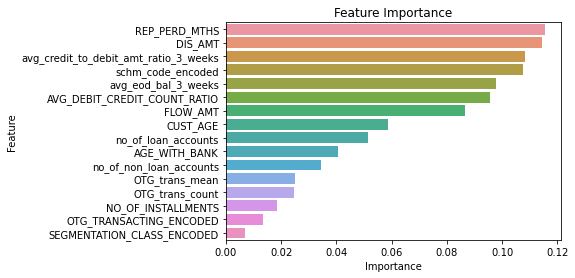

In [131]:
from sklearn.ensemble import RandomForestClassifier

X = df2[numerical_columns].fillna(0)
y = df2['DEFAULT_STATUS_ENCODED']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importances = rf.feature_importances_

features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=features)
plt.title('Feature Importance')
plt.show()


In [132]:
features.head(20)

,Feature,Importance
3,REP_PERD_MTHS,0.1
2,DIS_AMT,0.1
12,avg_credit_to_debit_amt_ratio_3_weeks,0.1
13,schm_code_encoded,0.1
11,avg_eod_bal_3_weeks,0.1
8,AVG_DEBIT_CREDIT_COUNT_RATIO,0.1
4,FLOW_AMT,0.1
0,CUST_AGE,0.1
9,no_of_loan_accounts,0.1
1,AGE_WITH_BANK,0.0


In [133]:
X = df2.drop(['DEFAULT_STATUS_ENCODED'], axis=1) 
y = df2['DEFAULT_STATUS_ENCODED'] 
top_features = features.head(9)['Feature'].tolist()

In [134]:
df2.DEFAULT_STATUS_ENCODED.value_counts()

0    452
1     63
Name: DEFAULT_STATUS_ENCODED, dtype: int64

In [135]:
df_majority = df2[df2.DEFAULT_STATUS_ENCODED == 0]
df_minority = df2[df2.DEFAULT_STATUS_ENCODED == 1]

df_majority_sampled = df_majority.sample(n=100, random_state=123)
df_minority_sampled = df_minority.sample(n=54, random_state=123)

df_sampled = pd.concat([df_majority_sampled, df_minority_sampled])

print(df_sampled.DEFAULT_STATUS_ENCODED.value_counts())

0    100
1     54
Name: DEFAULT_STATUS_ENCODED, dtype: int64


In [136]:
cif_ids = df_sampled['CIF_ID']

In [137]:
df_sampled.set_index('CIF_ID', inplace=True)

In [138]:
df_sampled.columns

Index(['CUST_AGE', 'AGE_WITH_BANK', 'DIS_AMT', 'REP_PERD_MTHS', 'FLOW_AMT',
       'NO_OF_INSTALLMENTS', 'OTG_trans_count', 'OTG_trans_mean',
       'AVG_DEBIT_CREDIT_COUNT_RATIO', 'no_of_loan_accounts',
       'no_of_non_loan_accounts', 'avg_eod_bal_3_weeks',
       'avg_credit_to_debit_amt_ratio_3_weeks', 'DEFAULT_STATUS_ENCODED',
       'schm_code_encoded', 'SEGMENTATION_CLASS_ENCODED',
       'OTG_TRANSACTING_ENCODED'],
      dtype='object')

In [153]:
df_sampled.fillna(0, inplace=True)

# Correctly dropping 'DEFAULT_STATUS_ENCODED' before selecting top features
df_sampled_modified = df_sampled.drop(['DEFAULT_STATUS_ENCODED'], axis=1)
X_selected = df_sampled_modified[top_features]

y_selected = df_sampled['DEFAULT_STATUS_ENCODED']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.20, random_state=42, stratify=y_selected)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Ensure any missing values are filled in the split datasets (might be redundant if df_sampled had no NaNs after filling)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train) 
y_pred = rf_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9354838709677419
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.82      0.90        11

    accuracy                           0.94        31
   macro avg       0.95      0.91      0.93        31
weighted avg       0.94      0.94      0.93        31

[[20  0]
 [ 2  9]]


In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [154]:
X_selected.columns

Index(['REP_PERD_MTHS', 'DIS_AMT', 'avg_credit_to_debit_amt_ratio_3_weeks',
       'schm_code_encoded', 'avg_eod_bal_3_weeks',
       'AVG_DEBIT_CREDIT_COUNT_RATIO', 'FLOW_AMT', 'CUST_AGE',
       'no_of_loan_accounts'],
      dtype='object')

In [141]:

y_pred = rf_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9354838709677419
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.82      0.90        11

    accuracy                           0.94        31
   macro avg       0.95      0.91      0.93        31
weighted avg       0.94      0.94      0.93        31

[[20  0]
 [ 2  9]]


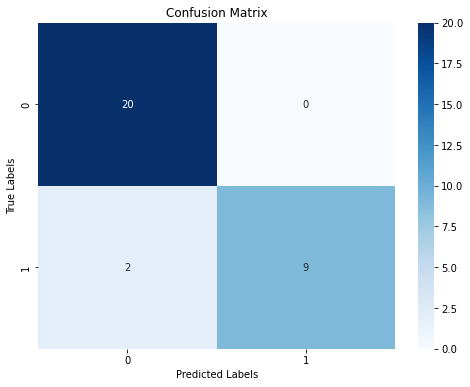

In [142]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [143]:
import pickle
filename = 'Nohyperparameter_01.sav'
pickle.dump(rf_clf, open(filename, 'wb'))


# HYPERPARAMETER TUNING 

In [144]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 6),
    'class_weight': [{0: 0.4, 1: 0.6}, {0: 0.3, 1: 0.7}, {0: 0.2, 1: 0.8}],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(rf, param_distributions=param_distributions, n_iter=100, cv=5, verbose=0, random_state=42, n_jobs=-1, scoring='accuracy')

random_search.fit(X_train, y_train)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best CV score: {random_search.best_score_}")


/Users/asha.anab/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/asha.anab/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/asha.anab/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

Best parameters: {'class_weight': {0: 0.2, 1: 0.8}, 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 271}
Best CV score: 0.836


In [145]:
rf_optimized = RandomForestClassifier(
    n_estimators=271,
    max_depth=6,
    min_samples_split=2,
    class_weight = {0: 0.2, 1: 0.8},
    min_samples_leaf=1,
    max_features= 'log2',
    random_state=42
)


rf_optimized.fit(X_train, y_train)


y_pred_optimized = rf_optimized.predict(X_test)


accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
class_report_optimized = classification_report(y_test, y_pred_optimized)
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)

print(f"Optimized Model Accuracy: {accuracy_optimized}")
print("Optimized Classification Report:")
print(class_report_optimized)
print("Optimized Confusion Matrix:")
print(conf_matrix_optimized)


Optimized Model Accuracy: 0.9354838709677419
Optimized Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.91      0.91      0.91        11

    accuracy                           0.94        31
   macro avg       0.93      0.93      0.93        31
weighted avg       0.94      0.94      0.94        31

Optimized Confusion Matrix:
[[19  1]
 [ 1 10]]


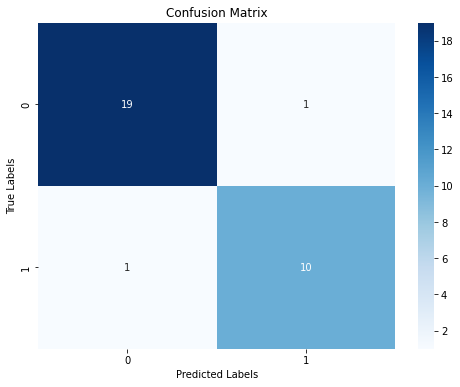

In [146]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_optimized)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [147]:
df_sampled.fillna(0, inplace=True)
predictions = rf_optimized.predict(X_selected)
probabilities = rf_optimized.predict_proba(X_selected)


In [148]:
results = pd.DataFrame({
    'CIF_ID': cif_ids,
    'Predictions': predictions,
    'Probabilities': probabilities[:, 1],  
    #'y_true': y_true 
})

In [149]:
import pickle
filename = 'hyperperameterw_01.sav'
pickle.dump(rf_optimized, open(filename, 'wb'))